Import libraries and Get Weather Station Info available from Met Eireann. 

In [145]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point
import requests
#import wget
from zipfile import ZipFile
import os

#Get Weather Stations details available from Met Eireann 
wsdf = pd.read_csv('https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv')
wsdf.head
print(wsdf.dtypes)

county           object
station name      int64
name             object
height(m)         int64
easting           int64
northing          int64
latitude        float64
longitude       float64
open year        object
close year       object
dtype: object


The Values in 'open year' and 'close year' are a combination of numeric text values and '(null)'
We want to analyse data from Weather Stations which have data from 2010 to the present
We'll convert the '(null)' to a future year '300' and convert to int.
This allows us to filter the data based on Year

In [146]:
#Convert Values in 'open year' and 'close year' from '(null)' to future year '3000'
wsdf[['open year', 'close year']] = wsdf[['open year', 'close year']].replace(['(null)'], '3000')
#Change 'open year' and 'close year' to int
wsdf[['open year', 'close year']] = wsdf[['open year', 'close year']].astype(int)
print(wsdf.dtypes)
#Filter Weather Stations to those reporting data fdrom 2013 to the present
ltywsdf=wsdf.loc[(wsdf['close year'] == 3000) & (wsdf['open year'] < 2014)]
ltywsdf.head

county           object
station name      int64
name             object
height(m)         int64
easting           int64
northing          int64
latitude        float64
longitude       float64
open year         int32
close year        int32
dtype: object


<bound method NDFrame.head of        county  station name                             name  height(m)  \
0      Antrim          5880                  LH_RATHLIN_WEST         10   
1      Carlow          4415              TULLOW (Waterworks)         76   
10     Carlow          6114             POLLMOUNTY FISH FARM         24   
15     Carlow           375                         OAK PARK         62   
17     Carlow          4515           TULLOW (Ardoyne Glebe)         79   
...       ...           ...                              ...        ...   
2074  Wicklow          9420  M.GLENMALURE (Cloghernagh For.)        436   
2075  Wicklow          9520   M.RATHDRUM (Ballintombay For.)        384   
2078  Wicklow          9820                    M.LOUGH OULER        457   
2079  Wicklow          2415            GLEN IMAAL (For.Stn.)        213   
2080  Wicklow          2420              OLDBRIDGE (Oakview)        335   

      easting  northing  latitude  longitude  open year  close year  

Verify the stations have a satisfactory geographical distribution by plotting the latitude and longitude

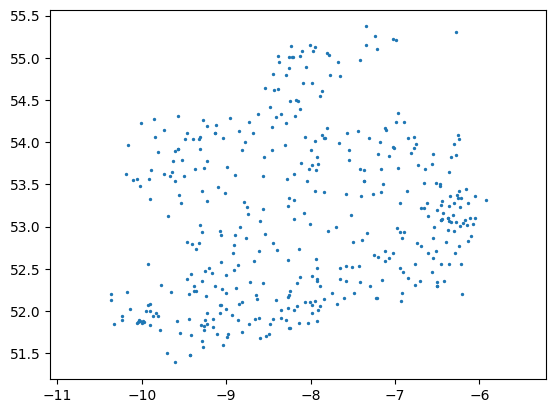

In [147]:
plt.scatter(x=ltywsdf['longitude'],y=ltywsdf['latitude'],s=2)
plt.axis('equal')

plt.show()


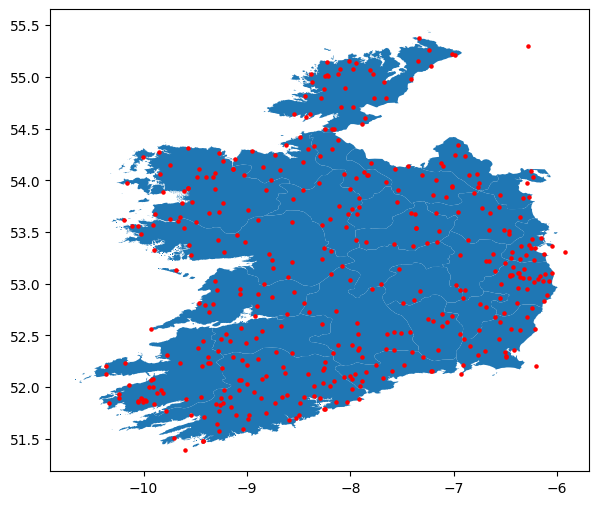

In [148]:
IRL_map= gpd.read_file('./IRL_adm/IRL_adm1.shp')  #reading the map 
geometry = [Point(xy) for xy in zip(ltywsdf['longitude'], ltywsdf['latitude'])]
gdf = GeoDataFrame(ltywsdf, geometry=geometry) 
gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);

Remove Rathlin Island Station from dataframe as it is not in scope here

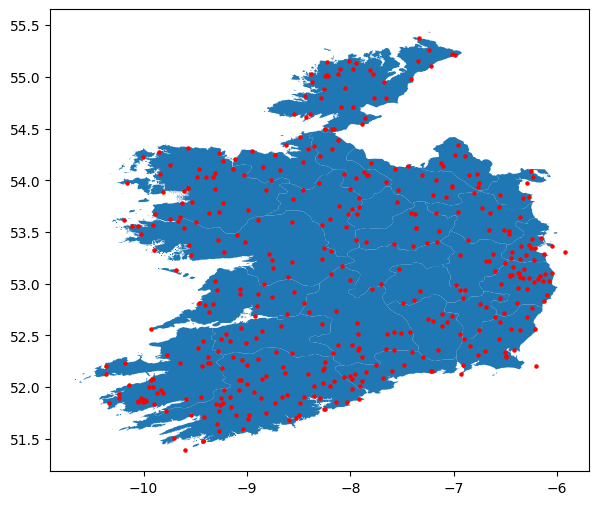

In [149]:
ltywsdf = ltywsdf.loc[ltywsdf["name"] != 'LH_RATHLIN_WEST']
geometry = [Point(xy) for xy in zip(ltywsdf['longitude'], ltywsdf['latitude'])]
gdf = GeoDataFrame(ltywsdf, geometry=geometry) 
gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);

Check if hourly data exists for the stations, if not drop it from the stations dataset, otherwise download and unzip the hourly data for the station

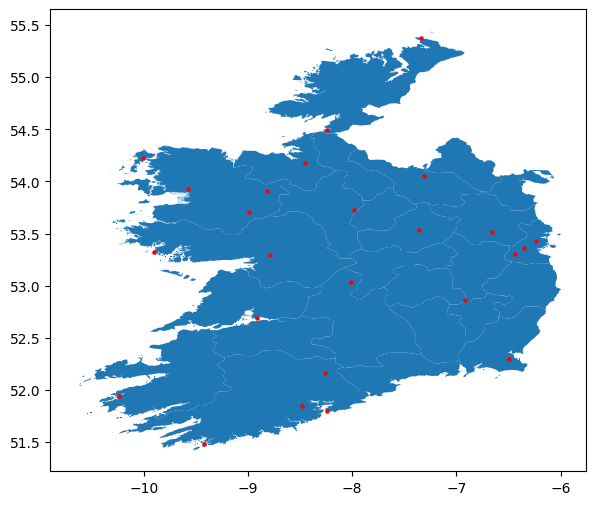

In [150]:
def url_checker(url):
	try:
		#Get Url
		get = requests.get(url)
		# if the request succeeds 
		if get.status_code == 200:
			return True
		else:
			return False
	#Exception
	except requests.exceptions.RequestException as e:
        # print URL with Errs
		return False

baseurl='https://cli.fusio.net/cli/climate_data/webdata/hly'
basezipfile='./weatherstationdata/zipped/hly'
baseunzipfile=basezipfile.replace("zipped", "unzipped")
for station in ltywsdf['station name']:
    stationurl=baseurl+str(station)+'.zip'
    stationzipfile=basezipfile+str(station)+'.zip'
    stationzipfolder=stationzipfile[:-4]
    stationunzipfolder=stationzipfolder.replace("zipped", "unzipped")
    if url_checker(stationurl):
        response = requests.get(stationurl)
        open(stationzipfile, "wb").write(response.content)
        #print(f"{stationurl} is found")
        with ZipFile(stationzipfile, 'r') as zip_ref:
                zip_ref.extractall(stationunzipfolder)
    else:
        ltywsdf = ltywsdf.loc[ltywsdf["station name"] != station]
geometry = [Point(xy) for xy in zip(ltywsdf['longitude'], ltywsdf['latitude'])]
gdf = GeoDataFrame(ltywsdf, geometry=geometry) 
gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);	


Get Distance between nearest neighbours

In [151]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree



import numpy as np
from sklearn.neighbors import BallTree

arcltywsdf=ltywsdf

ltywsdf.head
# the formula requires rad instead of degree
ltywsdf[["lat_rad", "lon_rad"]] = np.deg2rad(ltywsdf[["latitude", "longitude"]])

ball_tree = BallTree(ltywsdf[["lat_rad", "lon_rad"]], metric="haversine")

distances,neighbors = ball_tree.query(
    ltywsdf[["lat_rad", "lon_rad"]],
    k=2,  # k + 1 because we remove the address itself later, hence we need k - 1 = k_desired
    return_distance=True,  # choose whether you also want to return the distance
    sort_results=True,
)

# remove the address/point itself from the array because it itself is its nearest neighbour
neighbors = neighbors[:, 1:]
#print(neighbors)
distances = distances[:, 1:]

ltywsdf["nearest_stations"] = [
    ltywsdf["name"].iloc[n].to_list() for n in neighbors
]
ltywsdf["nearest_station_distance(rad)"] = distances
ltywsdf["nearest_station_distance(km)"] = distances*6371


ltywsdf.explode("nearest_stations")[["name", "nearest_stations"]]
#ltywsdf.explode("nearest_station_distance")[["name", "nearest_station_distance"]]
ltywsdf.head

<bound method NDFrame.head of          county  station name                  name  height(m)  easting  \
15       Carlow           375              OAK PARK         62   273000   
43        Cavan           675            BALLYHAISE         78   245200   
136       Clare           518       SHANNON AIRPORT         15   137900   
224        Cork           775         SherkinIsland         21   100781   
245        Cork          3904          CORK AIRPORT        155   166500   
353        Cork          1075          ROCHES POINT         40   182779   
367        Cork           575            MOORE PARK         46   181900   
478     Donegal          1575            MALIN HEAD         20   241939   
536     Donegal          2075                FINNER         33   184300   
600      Dublin          3723              CASEMENT         91   304100   
612      Dublin           175          PHOENIX PARK         48   309915   
624      Dublin           532        DUBLIN AIRPORT         71   31690

Plot a distribution of the Nearest Neighbour distances

<Axes: ylabel='Density'>

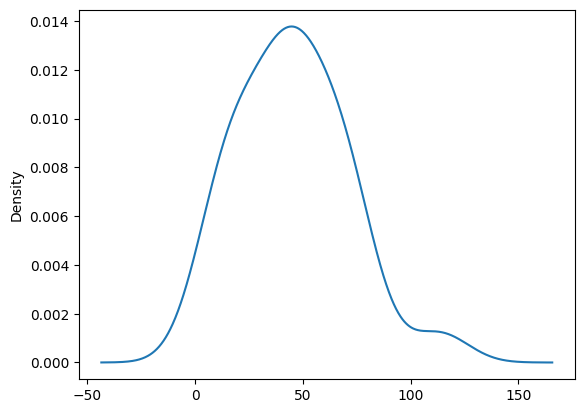

In [158]:
#ltywsdf.to_csv('C:/scripts/stationsdistance.csv')
ltywsdf["nearest_station_distance(km)"].plot(kind='kde')
#ltywsdf.describe()

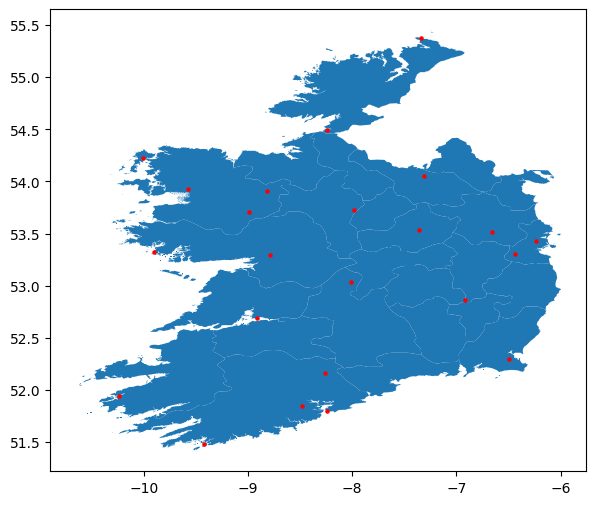

In [179]:
geometry = [Point(xy) for xy in zip(ltywsdf['longitude'], ltywsdf['latitude'])]
gdf = GeoDataFrame(ltywsdf, geometry=geometry) 
gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);	

For each file in ./weatherstationdata/unzipped unzip the archive
with file hly*.csv 
Find  'date:' and for each line until blank line create a dictionary
Find column headers starting with date, and read the rest of the file into dataframe
Rename the columns as per the dictionary
Delete unused columns

In [175]:

import os
wdict={}
stationunziphomefolder = basezipfile[:-4].replace('zipped','unzipped')
for folder in os.listdir(stationunziphomefolder):
    weatherdatafile=stationunziphomefolder+'/'+folder+"/"+folder+'.csv'
    #print(weatherdatafile)
    inblock=False
    with open(weatherdatafile, 'r') as wf:
        for lineno, line in enumerate(wf):
            if 'date:' in line or (inblock and line.strip()):
                inblock=True
                wdict[line.split(":")[0]] = line.split("-")[1].strip()
            else:
                if inblock:
                    break
    with open(weatherdatafile, 'r') as wf:
        for lineno, line in enumerate(wf):
                if 'date,' in line:
                    firstline = lineno
                    break 
    if (',wdsp' in line) or (',sun,' in line): 
        with open(weatherdatafile, 'r') as wf:
            for lineno, line in enumerate(wf):    
                lines=wf.readlines()   
        # Write file
        stationprochomefolder=stationunziphomefolder.replace('unzipped','processed')
        weatherdataprocfile=stationprochomefolder+"/"+weatherdatafile.split("/")[-1]
        with open(weatherdataprocfile, 'w') as wwf:
            # iterate each line
            for lineno, line in enumerate(lines):
                if lineno > (firstline-2):
                    wwf.write(line)
    else:
        print("Not Processing : "+folder)
        stationname=int(folder[3:])
        print(stationname)
        ltywsdf = ltywsdf.loc[ltywsdf["station name"] != stationname]
ltywsdf.shape
ltywsdf.head

Not Processing : hly1275
1275
Not Processing : hly175
175


<bound method NDFrame.head of          county  station name                  name  height(m)  easting  \
15       Carlow           375              OAK PARK         62   273000   
43        Cavan           675            BALLYHAISE         78   245200   
136       Clare           518       SHANNON AIRPORT         15   137900   
224        Cork           775         SherkinIsland         21   100781   
245        Cork          3904          CORK AIRPORT        155   166500   
353        Cork          1075          ROCHES POINT         40   182779   
367        Cork           575            MOORE PARK         46   181900   
478     Donegal          1575            MALIN HEAD         20   241939   
536     Donegal          2075                FINNER         33   184300   
600      Dublin          3723              CASEMENT         91   304100   
624      Dublin           532        DUBLIN AIRPORT         71   316900   
741      Galway           275             MACE HEAD         21    7340

In [177]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree



import numpy as np
from sklearn.neighbors import BallTree

arcltywsdf=ltywsdf

ltywsdf.head
# the formula requires rad instead of degree
ltywsdf[["lat_rad", "lon_rad"]] = np.deg2rad(ltywsdf[["latitude", "longitude"]])

ball_tree = BallTree(ltywsdf[["lat_rad", "lon_rad"]], metric="haversine")

distances,neighbors = ball_tree.query(
    ltywsdf[["lat_rad", "lon_rad"]],
    k=2,  # k + 1 because we remove the address itself later, hence we need k - 1 = k_desired
    return_distance=True,  # choose whether you also want to return the distance
    sort_results=True,
)

# remove the address/point itself from the array because it itself is its nearest neighbour
neighbors = neighbors[:, 1:]
#print(neighbors)
distances = distances[:, 1:]

ltywsdf["nearest_stations"] = [
    ltywsdf["name"].iloc[n].to_list() for n in neighbors
]
ltywsdf["nearest_station_distance(rad)"] = distances
ltywsdf["nearest_station_distance(km)"] = distances*6371


ltywsdf.explode("nearest_stations")[["name", "nearest_stations"]]
#ltywsdf.explode("nearest_station_distance")[["name", "nearest_station_distance"]]
ltywsdf.head

<bound method NDFrame.head of          county  station name                  name  height(m)  easting  \
15       Carlow           375              OAK PARK         62   273000   
43        Cavan           675            BALLYHAISE         78   245200   
136       Clare           518       SHANNON AIRPORT         15   137900   
224        Cork           775         SherkinIsland         21   100781   
245        Cork          3904          CORK AIRPORT        155   166500   
353        Cork          1075          ROCHES POINT         40   182779   
367        Cork           575            MOORE PARK         46   181900   
478     Donegal          1575            MALIN HEAD         20   241939   
536     Donegal          2075                FINNER         33   184300   
600      Dublin          3723              CASEMENT         91   304100   
624      Dublin           532        DUBLIN AIRPORT         71   316900   
741      Galway           275             MACE HEAD         21    7340

<Axes: ylabel='Density'>

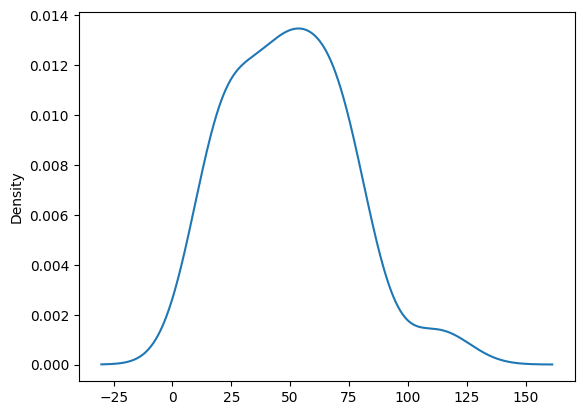

In [178]:
#ltywsdf.to_csv('C:/scripts/stationsdistance.csv')
ltywsdf["nearest_station_distance(km)"].plot(kind='kde')
#ltywsdf.describe()

In [176]:
ltywsdf.shape

(23, 16)

For each file in the processed folder,Substitute the column headers with the key values from the wdict list of key pairs

In [217]:
print(stationprochomefolder)
allwddf=pd. DataFrame()
startdate=pd.to_datetime('2013-01-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2023-01-01', format='%Y-%m-%d')
for file in os.listdir(stationprochomefolder):
    weatherdataprocfile=stationprochomefolder+"/"+file
    print(weatherdataprocfile)
    wddf = pd.read_csv(weatherdataprocfile)
    wddf['datetime'] = pd.to_datetime(wddf['date'], format='%d-%b-%Y %H:%M')
    wddf.head
    mask = (wddf['datetime']  >= startdate) & (wddf['datetime'] < enddate)
    wddf = wddf.loc[mask]
    columns = list(wddf.columns.values) 
    #for column in columns[::-1]:
    #    print(column)
    #retaincolumns=["datetime"]
    #wantedcolumns=["wdsp","wddir","sun"]
    for col in columns:
#        if col in wddf.columns:
#        retaincolumns.append(col)
        colloc=wddf.columns.get_loc(col)
#        print(colloc)
        if (wddf.columns[colloc-1].startswith('ind')):
            wddf.rename(columns={wddf.columns[colloc-1]: 'ind'+col}, inplace=True)
                #retaincolumns.append(wddf.columns[colloc-1])
#        else:
#            print(col+" not found")
#    print(retaincolumns)
#    wddf = wddf.loc[:, retaincolumns]
    wddf['station name'] = file[3:][:-4]

    break
#weatherdatafilename=weatherdatafile.split("/")[-1]
#print(weatherdatafilename)
##stationunprochomefolder=stationunziphomefolder.replace('unzipped','processed')
#print(stationunprochomefolder)
#foreach 
#wddf = pd.read_csv(weatherdatafile)
#wddf.columns = wddf.columns.to_series().map(wdict)
wddf.head    

./weatherstationdata/processed
./weatherstationdata/processed/hly1075.csv


C:\Users\czl\AppData\Local\Temp\ipykernel_45428\1627422374.py:8: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)


<bound method NDFrame.head of                      date  indrain rain  indtemp temp  indwetb wetb dewpt  \
481102  01-jan-2013 00:00        0  0.0        0  5.1        0  3.9   2.2   
481103  01-jan-2013 01:00        0  0.0        0  4.8        0  3.7   1.9   
481104  01-jan-2013 02:00        0  0.1        0  5.0        0  3.9   2.2   
481105  01-jan-2013 03:00        0  0.0        0  4.8        0  4.0   2.7   
481106  01-jan-2013 04:00        0  0.0        0  4.1        0  3.4   2.4   
...                   ...      ...  ...      ...  ...      ...  ...   ...   
568745  31-dec-2022 19:00        0  1.0        0  8.3        0  7.7   7.0   
568746  31-dec-2022 20:00        0  2.7        0  8.0        0  7.3   6.5   
568747  31-dec-2022 21:00        0  0.5        0  7.2        0  6.5   5.6   
568748  31-dec-2022 22:00        0  0.5        0  7.1        0  6.3   5.3   
568749  31-dec-2022 23:00        0  0.5        0  7.0        0  6.3   5.5   

       vappr rhum     msl  indwdsp wdsp  indw

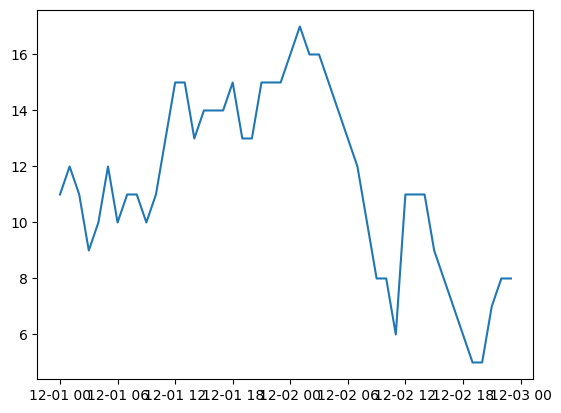

In [216]:
#plt.plot(wddf['datetime'], wddf['wsdf'])
wddf.head
startdate=pd.to_datetime('2022-12-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2022-12-03', format='%Y-%m-%d')
mask = (wddf['datetime']  >= startdate) & (wddf['datetime'] < enddate)
sample = wddf.loc[mask]
sample.head
#sampledate='2022-12-31'
#sample=wddf.loc[wddf['datetime']==sampledate]
plt.plot(sample['datetime'], sample['wdsp'])
#sample.head

Get the Actual Electricity Demand from https://www.smartgriddashboard.com/DashboardService.svc
Last 3o days data available by using this url.
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=demandActual&region=ALL&datefrom=04-Feb-2023%2000:00&dateto=05-Mar-2023%2023:59

Crafting urls by manipulating the url parameters allows the possibility of downloading data for custom timeframes.
Attempting to download a full year resulted in an empty file
It was possible to download data in monthly chunks like so
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=generationActual&region=ROI&datefrom=01-Dec-2022%2000:00&dateto=31-Dec-2022%2023:59

$baseurl="https://www.smartgriddashboard.com/DashboardService.svc/csv?area=generationActual&region=ROI&datefrom="
$separator="2%2000:00&dateto="


In [236]:
import calendar
from datetime import datetime

baseurl="https://www.smartgriddashboard.com/DashboardService.svc/csv?area=generationActual&region=ROI&datefrom="
separator="%2000:00&dateto="
end="%2023:59"
edfolder="./electricitydemand/"
edfileprefix='ElectricityDemandROIMonthly'
edfileextension='.csv'

for year in range(2013,2023):
    for month in range(1, 13):
        #print(month)
        input_dt = datetime(year, month, 1)
        datefrom=input_dt.strftime('%d-%b-%Y')
        res = calendar.monthrange(input_dt.year, input_dt.month)
        day = res[1]
        last_dt = datetime(year, month, day)
        dateto = last_dt.strftime('%d-%b-%Y')
        #print(dateto)
        monthto=last_dt.strftime('%Y%m')
        url=baseurl+datefrom+separator+dateto+end
        edfile=edfolder+edfileprefix+monthto+edfileextension
        print(url)
        print(edfile)
        if url_checker(url):
            response = requests.get(url)
            #print(response.content)
            open(edfile, "wb").write(response.content)    

""" input_dt = datetime(2022, 1, 1)
res = calendar.monthrange(input_dt.year, input_dt.month)
day = res[1]
print(f"Last date of month is: {input_dt.year}-{input_dt.month}-{day}") """

https://www.smartgriddashboard.com/DashboardService.svc/csv?area=generationActual&region=ROI&datefrom=01-Jan-2013%2000:00&dateto=31-Jan-2013%2023:59
./electricitydemand/ElectricityDemandROIMonthly201301.csv
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=generationActual&region=ROI&datefrom=01-Feb-2013%2000:00&dateto=28-Feb-2013%2023:59
./electricitydemand/ElectricityDemandROIMonthly201302.csv
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=generationActual&region=ROI&datefrom=01-Mar-2013%2000:00&dateto=31-Mar-2013%2023:59
./electricitydemand/ElectricityDemandROIMonthly201303.csv
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=generationActual&region=ROI&datefrom=01-Apr-2013%2000:00&dateto=30-Apr-2013%2023:59
./electricitydemand/ElectricityDemandROIMonthly201304.csv
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=generationActual&region=ROI&datefrom=01-May-2013%2000:00&dateto=31-May-2013%2023:59
./electricitydemand/Ele

' input_dt = datetime(2022, 1, 1)\nres = calendar.monthrange(input_dt.year, input_dt.month)\nday = res[1]\nprint(f"Last date of month is: {input_dt.year}-{input_dt.month}-{day}") '

In [ ]:
url="https://www.smartgriddashboard.com/DashboardService.svc/csv?area=generationActual&region=ROI&datefrom=01-Jan-20222%2000:00&dateto=31-Jan-2022%2023:59"
